In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets.folder import DatasetFolder
import torchvision
from torchvision import transforms, datasets
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, swin_t, Swin_T_Weights
import sklearn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import os

In [7]:
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
model.eval()
preprocess = weights.transforms()
img = read_image('/kaggle/input/dl-hw3/peppers-1-2.jpg')
preprocessed_img = preprocess(img).unsqueeze(0)
prediction = model(preprocessed_img).squeeze(0).softmax(0)
#class_id = prediction.argmax().item()
#score = prediction[class_id].item()
#category_name = weights.meta["categories"][class_id]
#print(f"{category_name}: {100 * score:.1f}%")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

The top 3 predictions of the ResNet18 model are - bell pepper (99.7%), cucumber (0.2%), zucchini (0.0%)

In [8]:
for id in list(prediction.topk(3).indices):
    cl_id = id.item()
    score = prediction[cl_id].item()
    cat_name = weights.meta["categories"][cl_id]
    print(f"{cat_name}: {100 * score:.1f}%")

bell pepper: 99.7%
cucumber: 0.2%
zucchini: 0.0%


It can be observed that the ResNet18 model classifies all 4 of the images correctly

In [9]:
tiger_img = read_image('/kaggle/input/dl-hw3/panthera_tigris.jpeg')
preprocessed_tiger_img = preprocess(tiger_img).unsqueeze(0)
prediction_tiger = model(preprocessed_tiger_img).squeeze(0).softmax(0)
class_id = prediction_tiger.argmax().item()
score_tiger = prediction_tiger[class_id].item()
category_tiger = weights.meta["categories"][class_id]
print(f'Tiger image classified as {category_tiger}')

Tiger image classified as tiger


In [10]:
cobra_img = read_image('/kaggle/input/dl-hw3/indian_cobra.jpeg')
preprocessed_cobra_img = preprocess(cobra_img).unsqueeze(0)
prediction_cobra = model(preprocessed_cobra_img).squeeze(0).softmax(0)
class_id = prediction_cobra.argmax().item()
score_tiger = prediction_cobra[class_id].item()
category_cobra = weights.meta["categories"][class_id]
print(f'Cobra image classified as {category_cobra}')

Cobra image classified as Indian cobra


In [11]:
hyena_img = read_image('/kaggle/input/dl-hw3/hyena.jpeg')
preprocessed_hyena_img = preprocess(hyena_img).unsqueeze(0)
prediction_hyena = model(preprocessed_hyena_img).squeeze(0).softmax(0)
class_id = prediction_hyena.argmax().item()
score_tiger = prediction_hyena[class_id].item()
category_hyena = weights.meta["categories"][class_id]
print(f'Hyena image classified as {category_hyena}')

Hyena image classified as hyena


In [12]:
model_weights =[]
conv_layers = []
model_children = list(model.children())
counter = 0
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 17
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(256

In [14]:
outputs = [conv_layers[0](preprocessed_img)]
names = ['Conv2D Layer 1']
for i,layer in enumerate(conv_layers[1:]):
    #print(i)
    #image = layer(preprocessed_img)
    output = layer(outputs[-1])
    outputs.append(output)
    #print(i)
    print(output.shape)
    names.append('Conv2D Layer ' + str(i + 2))
print(len(outputs))#print feature_maps
#for feature_map in outputs:
    #print(feature_map.shape)

torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
17


In [15]:
import matplotlib.pyplot as plt
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
    #for fm in processed:
        #print(fm.shape)

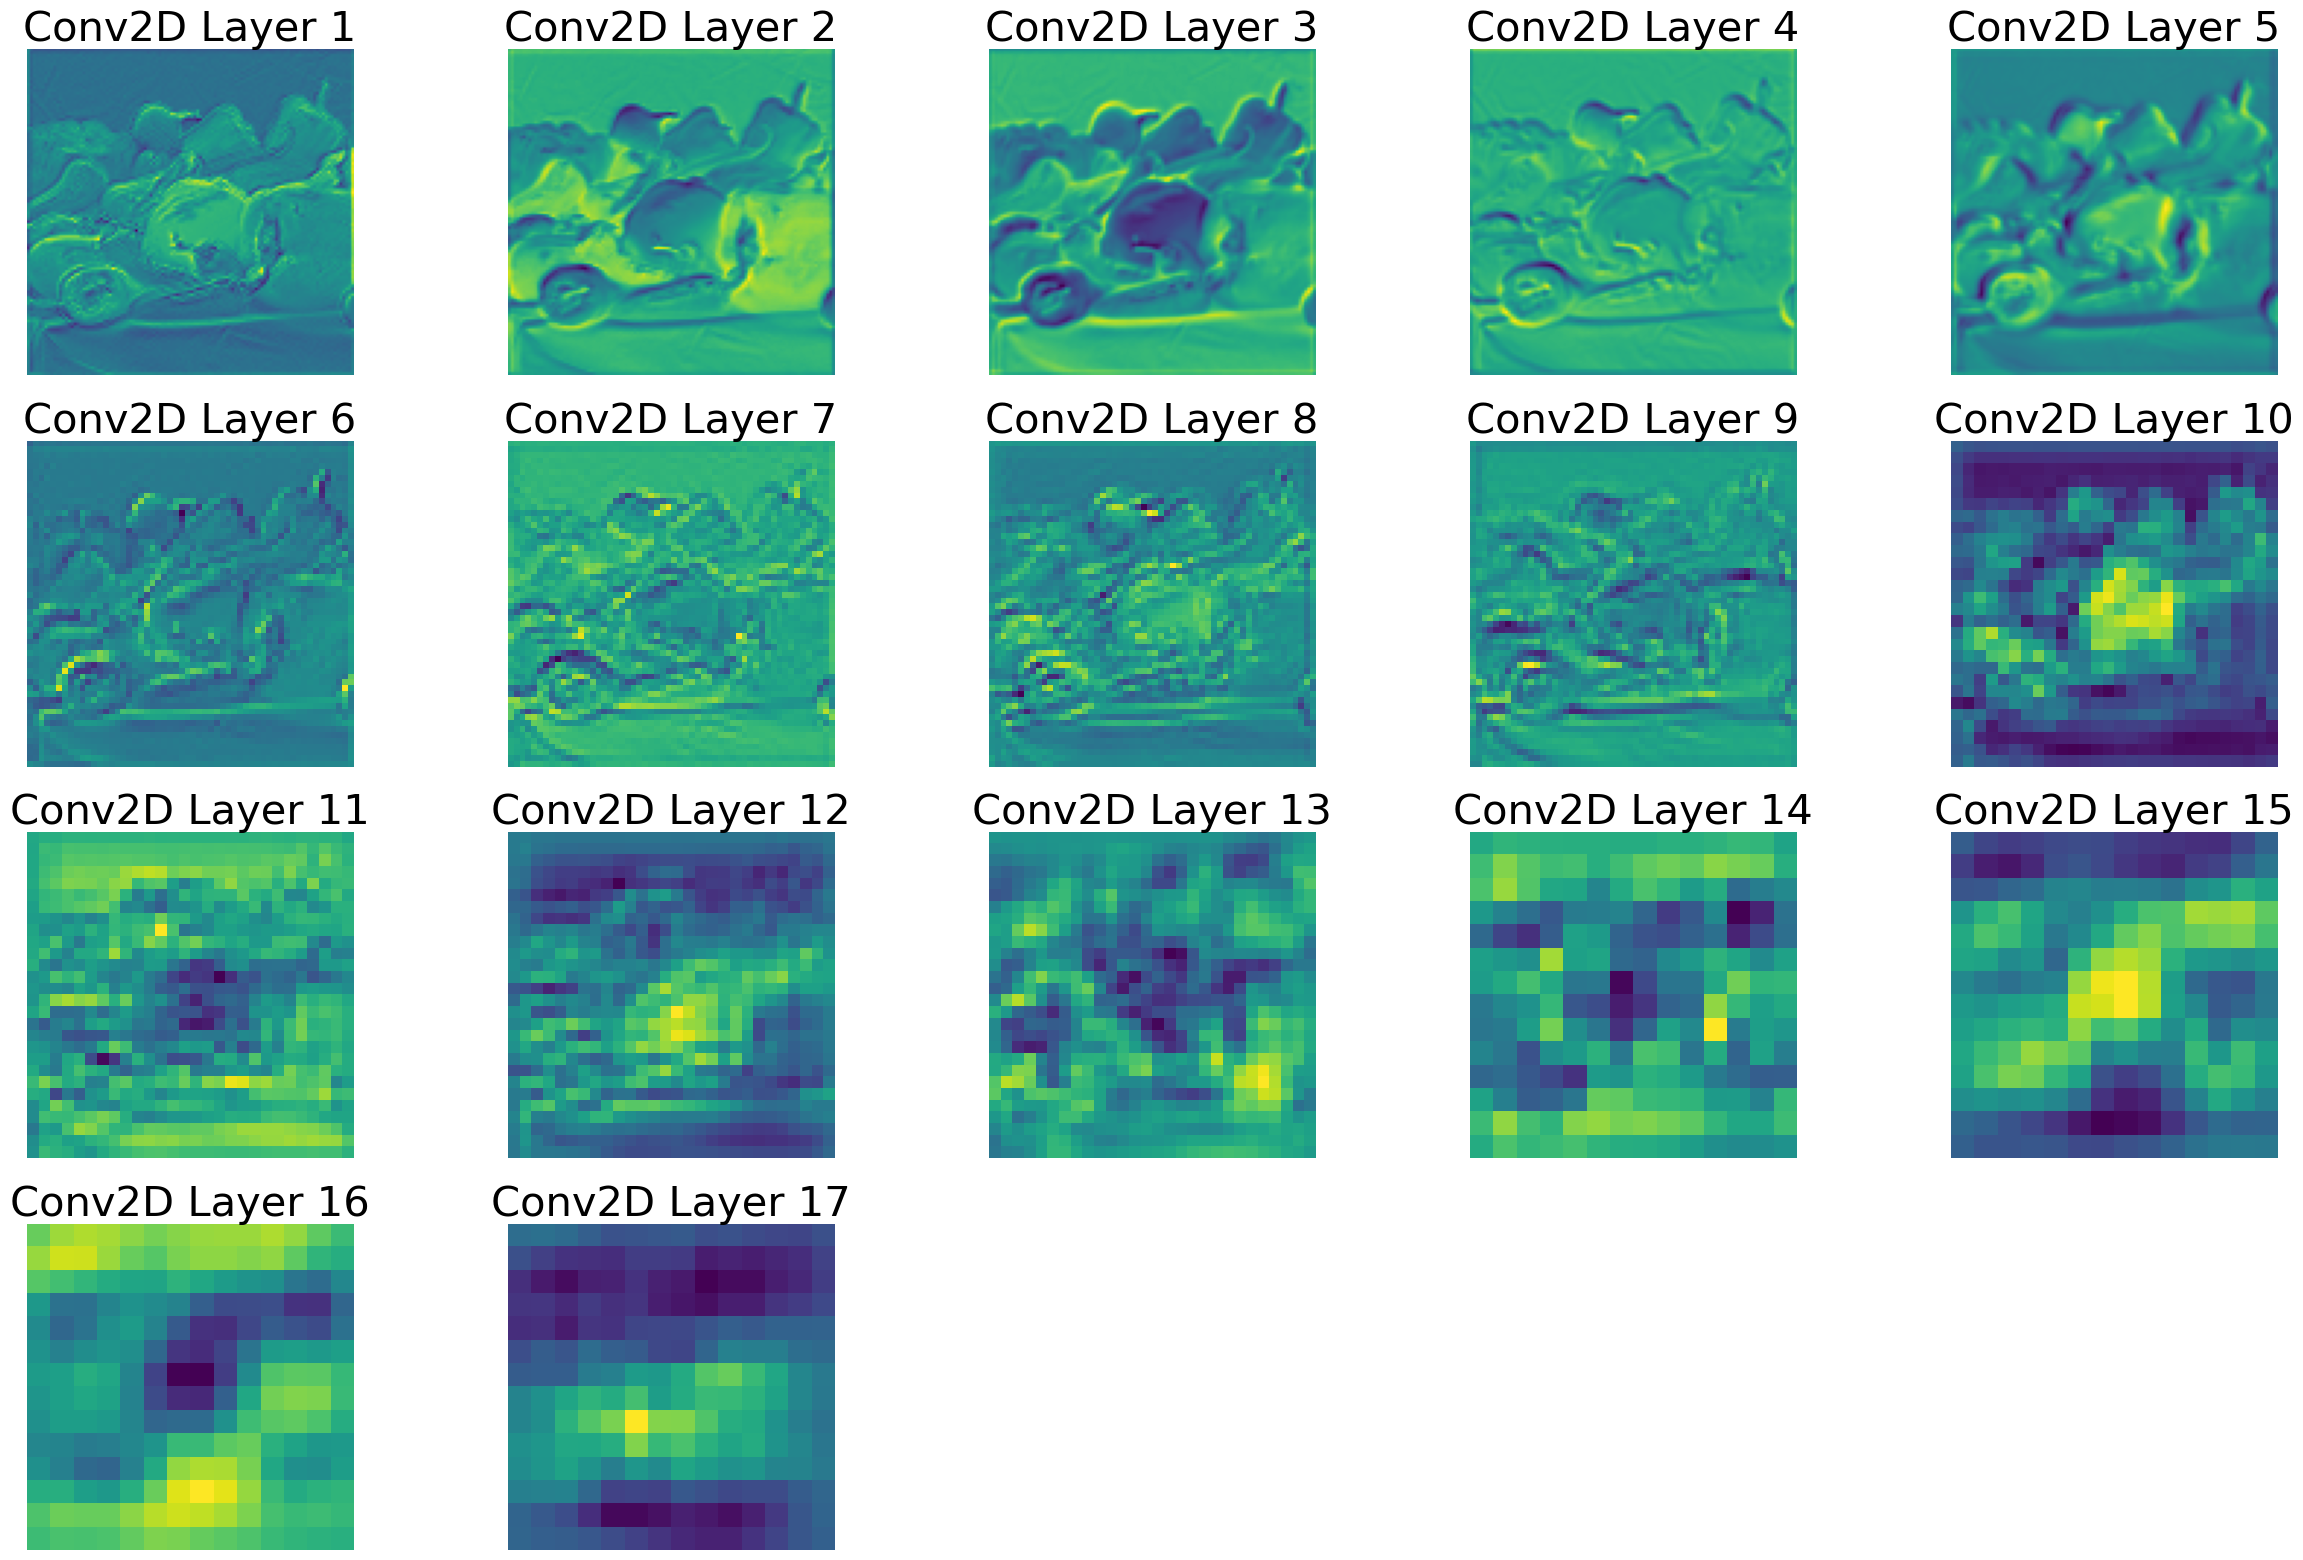

In [16]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(10, 5, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
from tqdm import tqdm
resnet_18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
pretrained_model = nn.Sequential(*list(resnet_18.children())[:-1])
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])
dataset = torchvision.datasets.OxfordIIITPet(root='/kaggle/working/',split='trainval',download=True,transform=transform)#datasets.ImageFolder(data_dir, transform=transform)
testset = torchvision.datasets.OxfordIIITPet(root='/kaggle/working/test/',split='test',download=True,transform=transform)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting /kaggle/working/oxford-iiit-pet/images.tar.gz to /kaggle/working/oxford-iiit-pet



  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting /kaggle/working/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/oxford-iiit-pet



  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting /kaggle/working/test/oxford-iiit-pet/images.tar.gz to /kaggle/working/test/oxford-iiit-pet



  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting /kaggle/working/test/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/test/oxford-iiit-pet


In [11]:
dataset.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

In [12]:
dataloader = DataLoader(dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)
pretrained_model = pretrained_model.cuda()
def extract_features(model, dataloader):
    features = []
    labels = []
    for images, targets in tqdm(dataloader):
        with torch.no_grad():
            images = images.cuda()
            features_batch = model(images)
            features_batch = features_batch.view(features_batch.size(0), -1)
            features.append(features_batch)
            labels.append(targets)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels
#features, labels = extract_features(pretrained_model, dataloader)
#features = nn.functional.normalize(features, p=2, dim=1)

In [13]:
def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

def predict(model, dataloader):
    model.eval()
    preds=[]
    test_acc=0
    pbar = pbar = tqdm(dataloader, desc=f"Test: Epoch {1}", total=len(dataloader), mininterval=5)
    with torch.no_grad():
        for images,labels in pbar:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            y_pred = F.softmax(outputs,dim = 1)
            top_p,top_class = y_pred.topk(1,dim = 1)
                
            label = labels.cpu().numpy()
            top_c = top_class.cpu().numpy() 
            test_acc += accuracy(outputs,labels)
    return test_acc/len(dataloader)
#resnet_18 = resnet_18.cuda()
#acc = predict(resnet_18, test_loader)
#print(f'Acc of pretrained resnet18: {acc}')

In [14]:
pretrained_model[-2]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [15]:
from sklearn.metrics import accuracy_score

class SoftmaxClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(num_features, num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

criterion = nn.CrossEntropyLoss()
classifier = SoftmaxClassifier(512, len(dataset.classes))
classifier = classifier.cuda()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-1)
epochs = 25

def transfer_learning_training(model, dataloader, epochs, classifier, optimizer):
    classifier.train()
    for ep in range(epochs):
        running_loss = 0
        train_accuracy = 0
        pbar = tqdm(dataloader, desc=f"Train: Epoch {ep + 1}", total=len(dataloader), mininterval=5)
        for images, labels in pbar:
            images = images.cuda()
            labels = labels.cuda()
            features = model(images)
            normalized_features = F.normalize(features, p=2, dim=1)
            output = classifier(normalized_features)
            loss = criterion(output, labels)
            train_accuracy += accuracy(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({"loss": loss.item()})
            running_loss += loss.item()
            
        loss = running_loss/len(dataloader)
        acc = train_accuracy/len(dataloader)
        print(f"Epoch {ep + 1} - Loss: {loss}")
        print(f"Epoch {ep + 1} - Acc: {acc}")
    torch.cuda.empty_cache()
        
def transfer_learning_eval(model, dataloader, epochs, classifier):
    classifier.eval()
    for ep in range(epochs):
        train_accuracy = 0
        pbar = tqdm(dataloader, desc=f"Eval: Epoch {ep + 1}", total=len(dataloader), mininterval=5)
        for images, labels in pbar:
            with torch.no_grad():
                images = images.cuda()
                labels = labels.cuda()
                features = pretrained_model(images)
                normalized_features = F.normalize(features, p=2, dim=1)
                output = classifier(normalized_features)
            train_accuracy += accuracy(output, labels)
            pbar.set_postfix({"loss": loss.item()})
            running_loss += loss.item()
            
        acc = training_accuracy/len(dataloader)
        print(f"Epoch {ep + 1} - Acc: {acc}")

def transfer_learning_predict(model, dataloader, classifier):
    model.eval()
    classifier.eval()
    preds=[]
    test_acc=0
    pbar = pbar = tqdm(dataloader, desc=f"Test: Epoch {1}", total=len(dataloader), mininterval=5)
    with torch.no_grad():
        for images,labels in pbar:
            images = images.cuda()
            labels = labels.cuda()
            features = model(images)
            normalized_features = F.normalize(features, p=2, dim=1)
            outputs = classifier(normalized_features)
            y_pred = F.softmax(outputs,dim = 1)
            top_p,top_class = y_pred.topk(1,dim = 1)
                
            label = labels.cpu().numpy()
            top_c = top_class.cpu().numpy() 
            test_acc += accuracy(outputs,labels)
    torch.cuda.empty_cache()
    return test_acc/len(dataloader)

def transfer_learning(pretrained_model, trainloader, testloader, epochs, classifier, optimizer):
    transfer_learning_training(pretrained_model, trainloader, epochs, classifier, optimizer)
    test_acc = transfer_learning_predict(pretrained_model, testloader, classifier)
    print(f'Mean per class accuracy on Test Set: {test_acc*100}%')
    return test_acc

test_acc = transfer_learning(pretrained_model, dataloader, test_loader, epochs, classifier, optimizer)

Train: Epoch 1: 100%|██████████| 8/8 [00:35<00:00,  4.41s/it, loss=4.74]


Epoch 1 - Loss: 4.579407840967178

Epoch 1 - Acc: 0.061767578125


Train: Epoch 2: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it, loss=1.72]


Epoch 2 - Loss: 2.988766074180603

Epoch 2 - Acc: 0.1832682192325592


Train: Epoch 3: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=2.74]


Epoch 3 - Loss: 2.1779716461896896

Epoch 3 - Acc: 0.4742838442325592


Train: Epoch 4: 100%|██████████| 8/8 [00:29<00:00,  3.73s/it, loss=1.3]


Epoch 4 - Loss: 1.4074680358171463

Epoch 4 - Acc: 0.8255208134651184


Train: Epoch 5: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it, loss=1.1]


Epoch 5 - Loss: 1.2802632302045822

Epoch 5 - Acc: 0.7542317509651184


Train: Epoch 6: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it, loss=1.12]


Epoch 6 - Loss: 1.0048179775476456

Epoch 6 - Acc: 0.8509114384651184


Train: Epoch 7: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it, loss=0.723]


Epoch 7 - Loss: 0.858343742787838

Epoch 7 - Acc: 0.8582356572151184


Train: Epoch 8: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it, loss=0.722]


Epoch 8 - Loss: 0.7893179580569267

Epoch 8 - Acc: 0.8671875


Train: Epoch 9: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it, loss=0.647]


Epoch 9 - Loss: 0.6975664868950844

Epoch 9 - Acc: 0.8843587040901184


Train: Epoch 10: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=0.549]


Epoch 10 - Loss: 0.646865114569664

Epoch 10 - Acc: 0.891357421875


Train: Epoch 11: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=0.521]


Epoch 11 - Loss: 0.6022048518061638

Epoch 11 - Acc: 0.900146484375


Train: Epoch 12: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=0.474]


Epoch 12 - Loss: 0.5611020959913731

Epoch 12 - Acc: 0.907470703125


Train: Epoch 13: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it, loss=0.434]


Epoch 13 - Loss: 0.530001413077116

Epoch 13 - Acc: 0.9130859375


Train: Epoch 14: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=0.407]


Epoch 14 - Loss: 0.5009666606783867

Epoch 14 - Acc: 0.9203287959098816


Train: Epoch 15: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it, loss=0.379]


Epoch 15 - Loss: 0.47558432072401047

Epoch 15 - Acc: 0.92626953125


Train: Epoch 16: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=0.354]


Epoch 16 - Loss: 0.453365508466959

Epoch 16 - Acc: 0.9296875


Train: Epoch 17: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it, loss=0.334]


Epoch 17 - Loss: 0.43296896666288376

Epoch 17 - Acc: 0.933837890625


Train: Epoch 18: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it, loss=0.315]


Epoch 18 - Loss: 0.414589274674654

Epoch 18 - Acc: 0.937255859375


Train: Epoch 19: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it, loss=0.298]


Epoch 19 - Loss: 0.3978285789489746

Epoch 19 - Acc: 0.93994140625


Train: Epoch 20: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it, loss=0.282]


Epoch 20 - Loss: 0.38240763917565346

Epoch 20 - Acc: 0.94189453125


Train: Epoch 21: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it, loss=0.268]


Epoch 21 - Loss: 0.36819665506482124

Epoch 21 - Acc: 0.944580078125


Train: Epoch 22: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it, loss=0.256]


Epoch 22 - Loss: 0.35503964871168137

Epoch 22 - Acc: 0.947021484375


Train: Epoch 23: 100%|██████████| 8/8 [00:30<00:00,  3.77s/it, loss=0.244]


Epoch 23 - Loss: 0.3428157176822424

Epoch 23 - Acc: 0.950439453125


Train: Epoch 24: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it, loss=0.234]


Epoch 24 - Loss: 0.33141834661364555

Epoch 24 - Acc: 0.952392578125


Train: Epoch 25: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it, loss=0.224]


Epoch 25 - Loss: 0.3207663744688034

Epoch 25 - Acc: 0.955078125


Test: Epoch 1: 100%|██████████| 58/58 [00:26<00:00,  2.19it/s]

Mean per class accuracy on Test Set: 82.88818359375%


In [18]:
swin_transformer = swin_t(weights=Swin_T_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


  0%|          | 0.00/108M [00:00<?, ?B/s]

It can be observed that the swin transformer classifies all the 4 images correctly just like the ResNet-18 model. The difference between the two models cannot be determined from the 4 images on bell peppers, tigers, indian cobras and hyenas.

In [22]:
img = read_image('/kaggle/input/dl-hw3/peppers-1-2.jpg')
preprocessed_img = preprocess(img).unsqueeze(0)
prediction = swin_transformer(preprocessed_img).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

bell pepper: 88.7%


In [19]:
tiger_img = read_image('/kaggle/input/dl-hw3/panthera_tigris.jpeg')
preprocessed_tiger_img = preprocess(tiger_img).unsqueeze(0)
prediction_tiger = swin_transformer(preprocessed_tiger_img).squeeze(0).softmax(0)
class_id = prediction_tiger.argmax().item()
score_tiger = prediction_tiger[class_id].item()
category_tiger = weights.meta["categories"][class_id]
print(f'Tiger image classified as {category_tiger}')

Tiger image classified as tiger


In [20]:
cobra_img = read_image('/kaggle/input/dl-hw3/indian_cobra.jpeg')
preprocessed_cobra_img = preprocess(cobra_img).unsqueeze(0)
prediction_cobra = swin_transformer(preprocessed_cobra_img).squeeze(0).softmax(0)
class_id = prediction_cobra.argmax().item()
score_tiger = prediction_cobra[class_id].item()
category_cobra = weights.meta["categories"][class_id]
print(f'Cobra image classified as {category_cobra}')

Cobra image classified as Indian cobra


In [21]:
hyena_img = read_image('/kaggle/input/dl-hw3/hyena.jpeg')
preprocessed_hyena_img = preprocess(hyena_img).unsqueeze(0)
prediction_hyena = swin_transformer(preprocessed_hyena_img).squeeze(0).softmax(0)
class_id = prediction_hyena.argmax().item()
score_tiger = prediction_hyena[class_id].item()
category_hyena = weights.meta["categories"][class_id]
print(f'Hyena image classified as {category_hyena}')

Hyena image classified as hyena


In [17]:
pretrained_swin_t = nn.Sequential(*list(swin_transformer.children())[:-1])

In [18]:
train_loader_transformer = DataLoader(dataset, batch_size=128, shuffle=False)
classifier_new = SoftmaxClassifier(768, len(dataset.classes))
pretrained_swin_t = pretrained_swin_t.cuda()
classifier_new = classifier_new.cuda()
optimizer_new = torch.optim.AdamW(classifier_new.parameters(), lr=1e-1)
test_acc_transformer = transfer_learning(pretrained_swin_t, train_loader_transformer, test_loader, 12, classifier_new, optimizer_new)

Train: Epoch 1: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it, loss=0.837]


Epoch 1 - Loss: 3.5234938613299667

Epoch 1 - Acc: 0.3999640643596649


Train: Epoch 2: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it, loss=0.059]


Epoch 2 - Loss: 0.664980078437205

Epoch 2 - Acc: 0.7859195470809937


Train: Epoch 3: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it, loss=0.0554]


Epoch 3 - Loss: 0.37783545217123526

Epoch 3 - Acc: 0.8794001340866089


Train: Epoch 4: 100%|██████████| 29/29 [00:51<00:00,  1.79s/it, loss=0.0403]


Epoch 4 - Loss: 0.3199638012668182

Epoch 4 - Acc: 0.904633641242981


Train: Epoch 5: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it, loss=0.0229]


Epoch 5 - Loss: 0.3110411777963926

Epoch 5 - Acc: 0.9051724076271057


Train: Epoch 6: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it, loss=0.00872]


Epoch 6 - Loss: 0.2599765594470604

Epoch 6 - Acc: 0.920258641242981


Train: Epoch 7: 100%|██████████| 29/29 [00:52<00:00,  1.79s/it, loss=0.022]


Epoch 7 - Loss: 0.2201461503603335

Epoch 7 - Acc: 0.938847005367279


Train: Epoch 8: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it, loss=0.0361]


Epoch 8 - Loss: 0.20394692582816915

Epoch 8 - Acc: 0.9411817789077759


Train: Epoch 9: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it, loss=0.00984]


Epoch 9 - Loss: 0.19086791687355986

Epoch 9 - Acc: 0.943965494632721


Train: Epoch 10: 100%|██████████| 29/29 [00:52<00:00,  1.79s/it, loss=0.0203]


Epoch 10 - Loss: 0.1697197949578022

Epoch 10 - Acc: 0.951508641242981


Train: Epoch 11: 100%|██████████| 29/29 [00:52<00:00,  1.80s/it, loss=0.0428]


Epoch 11 - Loss: 0.179098026505832

Epoch 11 - Acc: 0.9440553188323975


Train: Epoch 12: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it, loss=0.0183]


Epoch 12 - Loss: 0.15590886932251782

Epoch 12 - Acc: 0.9563577771186829


Test: Epoch 1: 100%|██████████| 58/58 [00:34<00:00,  1.68it/s]

Mean per class accuracy on Test Set: 90.89311218261719%


It was observed that the Swin Transformer (SWIN_T) achieved an accuracy of 90.89% on the Test Set as opposed to the Test accuracy of 82.88%. This can be explained by the fact that the Swin Transformer is a much larger and a more complex model than the ResNet-18.